# Data Visualization

__We will produce visualization for our project here as well for use in the arxiv paper__

---
## Education Desert Visuals
__In this section we will create visuals that we will use in our arxiv paper__

In [1]:
# Library Imports
import fiona 
import rtree
import shapely
from shapely.geometry import MultiPoint
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
import pandas as pd
import geopandas as gpd
import numpy as np

import json
from time import time
import subprocess
import os
from os import listdir
from os.path import isfile, join
import requests
from bs4 import BeautifulSoup
import seaborn as sns

# default dictionary (a dictionary with a default value if a key doesn't exist)
from collections import defaultdict

# To unzip file
import zipfile

# To have progress bar
from tqdm import tqdm

# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

# Helper function to create a new folder
def mkdir(path):
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
        else:
            print("(%s) already exists" % (path))

---
## Datasets

In [2]:
# Census tracts data url from 2012 - 2017
ct_file_name = 'acs_5_year_estimates_census_tracts.csv'

# American University Data
au_file_name = 'IPEDS_data.xlsx'

# Directory of datasets
DATASETS_PATH = 'datasets/'

# Directory of census tract shapefile data
CENSUS_TRACTS_PATH = join(DATASETS_PATH, 'census_tracts/')

# JSON file for dictionary of census tracts 
# and the census tracts within BUFFER
tracts_in_buffer_file_name = 'tracts_in_buffer.json'

# CSV file containing the labels of
# each census tract being an education desert or not
education_deserts_file_name = 'education_deserts.csv'

# CSV file containing the census tract features and
# feature engineered features along with label of 
# education desert or not
census_tract_feats_file_name = 'census_tract_feats.csv'

In [3]:
merged_census_df = pd.read_csv(join(DATASETS_PATH,census_tract_feats_file_name), index_col='geoID')
merged_census_df.head()

,Total Population:,Population Density (Per Sq. Mile),Total Population: Male,Total Population: White Alone,Total Population: Black or African American Alone,Total Population: American Indian and Alaska Native Alone,Total Population: Asian Alone,Total Population: Native Hawaiian and Other Pacific Islander Alone,Total Population: Some Other Race Alone,Total Population: Two or More Races,...,"Pct. Households: $100,000 to $124,999","Pct. Households: $125,000 to $149,999","Pct. Households: $150,000 to $199,999","Pct. Households: $200,000 or More",Pct. Families below poverty level,Pct. Population for Whom Poverty Status Is Determined: Under 1.00 (Doing Poorly),Pct. Population for Whom Poverty Status Is Determined: 1.00 to 1.99 (Struggling),Pct. Population for Whom Poverty Status Is Determined: Under 2.00 (Poor or Struggling),Number of Accessible Universities,Education Desert
geoID,,,,,,,,,,,,,,,,,,,,,
1001020100,1845,487.1106,899,1636,96,0,22,0,0,91,...,0.074271,0.079576,0.090186,0.021220,0.120287,0.106775,0.117073,0.223848,5,0
1001020200,2172,1684.0130,1167,913,1184,0,22,14,7,32,...,0.089400,0.040868,0.015326,0.000000,0.182903,0.224138,0.220588,0.444726,5,0
1001020300,3385,1638.9340,1533,2078,896,19,25,12,272,83,...,0.078968,0.039093,0.027365,0.000000,0.100363,0.146529,0.280650,0.427179,5,0
1001020400,4267,1731.4730,2001,3443,356,20,10,0,320,118,...,0.104631,0.032590,0.038308,0.005146,0.014617,0.022967,0.182564,0.205531,5,0
1001020500,9965,2264.4190,5054,7817,1638,0,305,0,0,205,...,0.178827,0.048164,0.054125,0.020029,0.084132,0.122349,0.133108,0.255457,5,0


---
## Histograms

__Let's plot a Histogram of the Percentage of people with bachelor’s degrees (education deserts in red, non education deserts in blue)__

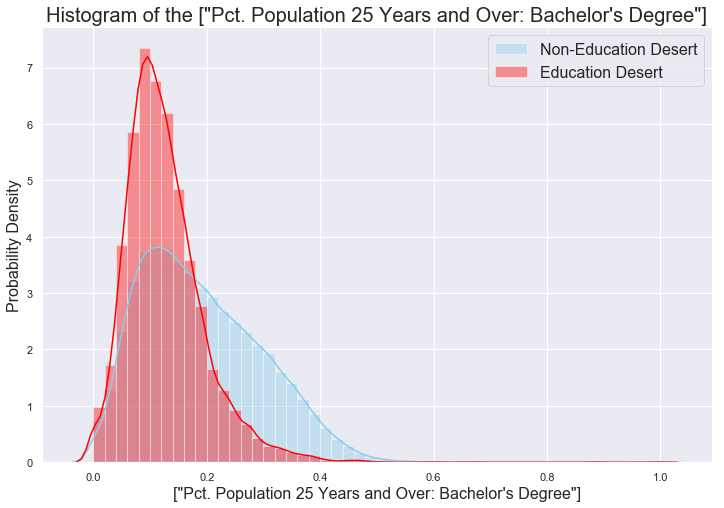

In [4]:
def feature_hist(features, df):
    '''
    This function creates Histograms of the desired feature

    INPUT: (list(str)) Census Tract feature to be visualized
           (Pandas DataFrame) Census Tract Features dataframe
    OUTPUT: Histograms of the Feature specified for Education Deserts and Non-education deserts overlayed
            on top of one another.
    '''
    sns.set()
    if len(features) > 1:
        fig, axes = plt.subplots(int(np.sqrt(len(features))), int(np.sqrt(len(features))), figsize=(16, 16), sharex=True)
        for idx, feat in enumerate(features):
            sns.distplot(df[df['Education Desert'] == 0][feat] , color="skyblue", hist_kws={"alpha": 1}, ax=axes[idx//4, idx%4], label="Non-Education Desert")
            sns.distplot(df[df['Education Desert'] == 1][feat] , color="red", hist_kws={"alpha": 0.4}, ax=axes[idx//4, idx%4], label="Education Desert")
            plt.xlim(xmax=0.25)
        plt.legend();
    else:
        rcParams['figure.figsize'] = 12, 8
        sns.distplot(df[df['Education Desert'] == 0][features] , color="skyblue", label="Non-Education Desert")
        sns.distplot(df[df['Education Desert'] == 1][features] , color="red", label="Education Desert")
        plt.title('Histogram of the {}'.format(features), fontsize=20)
        plt.ylabel('Probability Density', fontsize=16)
        plt.xlabel(features, fontsize=16)
        plt.grid(True)
        plt.legend(fontsize=16);
    
feature_hist(['Pct. Population 25 Years and Over: Bachelor\'s Degree'], merged_census_df)

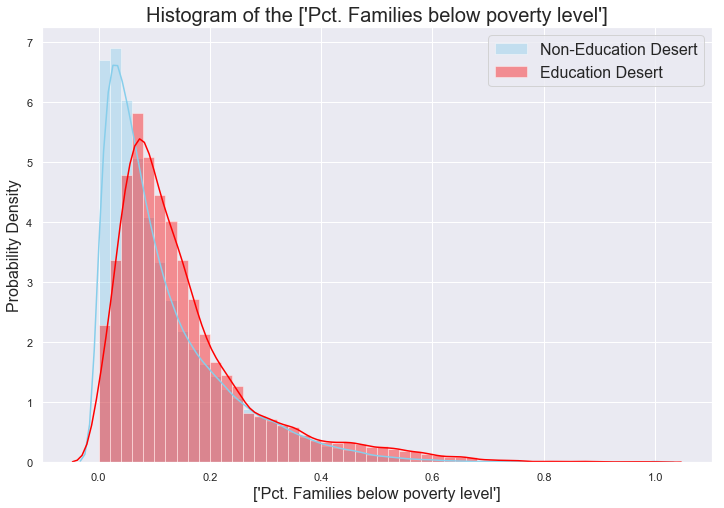

In [5]:
feature_hist(['Pct. Families below poverty level'], merged_census_df)

In [6]:
# Get all the features related to income
pct_income_feats = [feat for feat in merged_census_df.columns if feat[:len('Pct. Households: ')] == 'Pct. Households: ']
len(pct_income_feats)

16

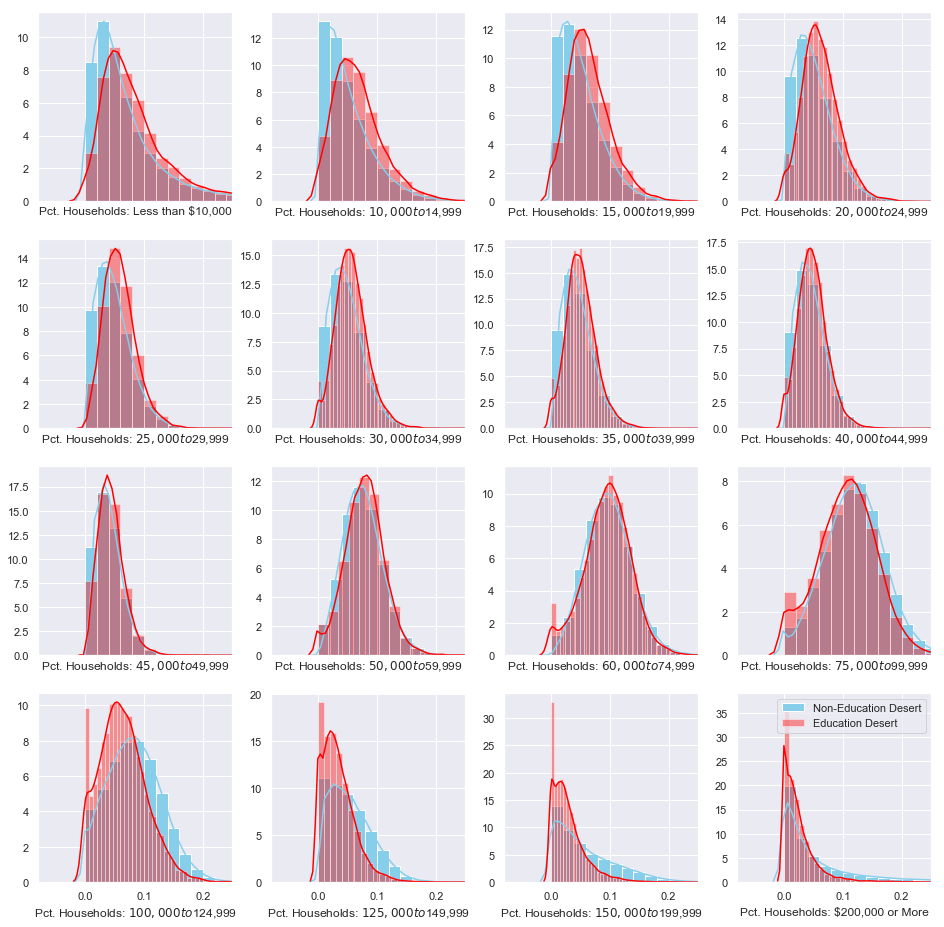

In [7]:
feature_hist(pct_income_feats, merged_census_df);

---
## Education Deserts

__Let's plot all the Education Desert census tracts__

In [8]:
# ----------------------------
# Let's store a list of each census 
# tract's geometry as well
tract_list = []
    
for subdir, dirs, files in list(os.walk(CENSUS_TRACTS_PATH))[1:]:
    
    # Opening the shapefile
    state_shapes = fiona.open(subdir, 'r')
    
    # Looping through each census tract in each state and 
    # making key: geoid, value: centroid position
    # of (longitude, latitude) as well as building the 
    # RTree index for census tracts
    for idx, census_tract in enumerate(state_shapes):
        
        geoid = census_tract['properties']['GEOID']
        
        # ----------------------------
        # Create Census tract Polygon
        tract = shapely.geometry.shape(census_tract['geometry'])
        
        # ----------------------------
        # Store the Census tract Polygon
        # in our list for the RTree index
        # later on
        tract_list.append((geoid, tract))

In [9]:
# Setting our coordinate system for the tracts 
# and universities to EPSG:2163 https://epsg.io/2163
tract_gdf = gpd.GeoDataFrame(geometry=[tract_shape for geoid, tract_shape in tract_list], index=[geoid for geoid, tract_pt in tract_list])
tract_gdf.crs = {'init': 'epsg:4269'}
tract_gdf.to_crs({'init': 'epsg:2163'}, inplace=True)

In [10]:
tract_gdf.head()

,geometry
29001950900,POLYGON ((629242.0316918371 -506221.3254062997...
29007950100,POLYGON ((726058.4147780467 -594058.6638516618...
29009960100,POLYGON ((549396.9598456144 -886283.8071082532...
29019001201,POLYGON ((657151.3594785809 -643289.4193804697...
29021000600,POLYGON ((441856.9767450066 -565820.0687293162...


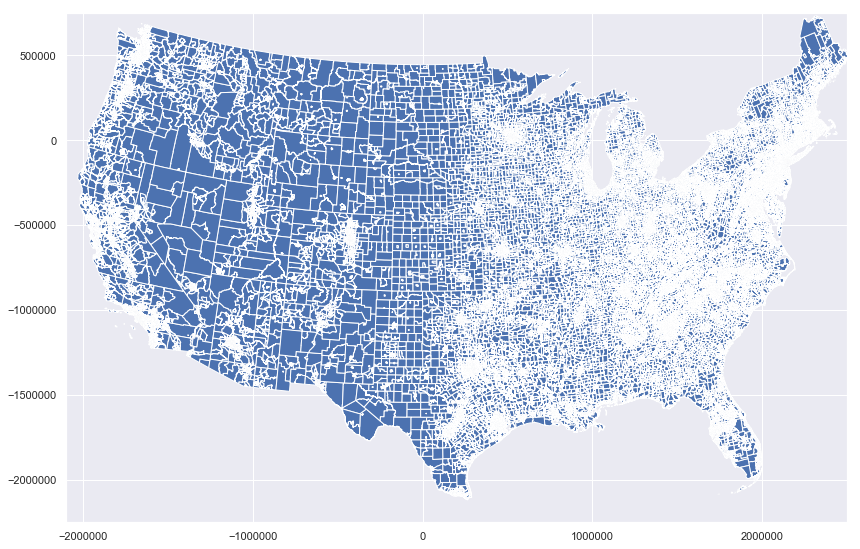

In [11]:
sns.set()
tract_gdf.plot(figsize=(14, 14))
plt.xlim(left=-2.10*1e6, right=2.5*1e6)
plt.ylim(bottom=-2.25*1e6, top=0.75*1e6)
plt.grid(True);

__Let's gather all the shapes of the education deserts__

In [12]:
education_deserts = [(geometry.values[0], merged_census_df.loc[int(geoid)]['Number of Accessible Universities']) for geoid, geometry in tract_gdf.iterrows() if int(geoid) in merged_census_df.index and int(merged_census_df.loc[int(geoid)]['Education Desert']) == 1]

In [13]:
len(education_deserts)

10230

__Let's gather all the shapes of the non-education deserts__

In [14]:
non_education_deserts = [(geometry.values[0], merged_census_df.loc[int(geoid)]['Number of Accessible Universities']) for geoid, geometry in tract_gdf.iterrows() if int(geoid) in merged_census_df.index and int(merged_census_df.loc[int(geoid)]['Education Desert']) == 0]

In [15]:
len(non_education_deserts)

63515

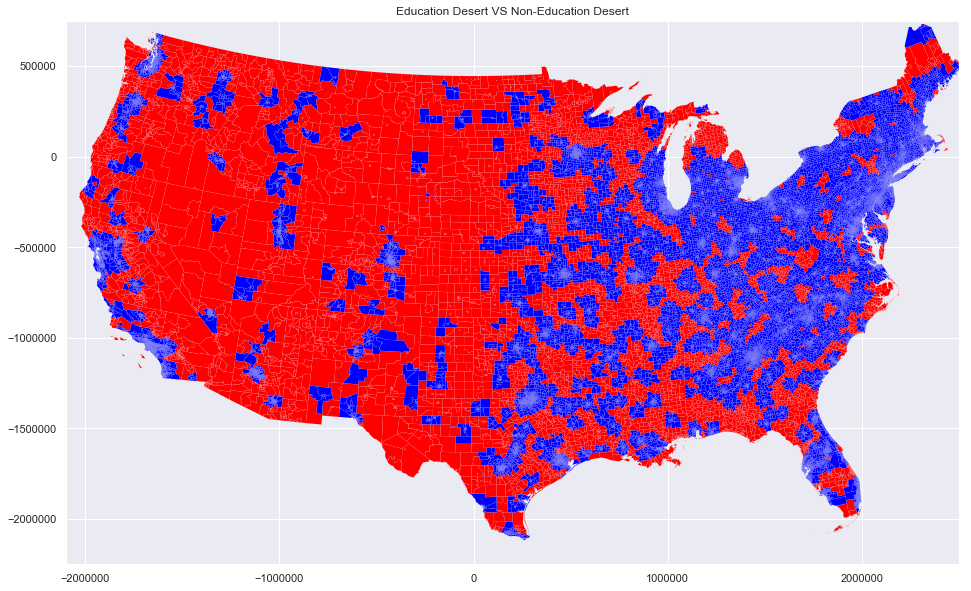

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10), sharex=True)
for ed_tract, _ in education_deserts:
    ax.add_patch(PolygonPatch(ed_tract, fc='red', ec=[1,1,1], linewidth=0.05))
for non_ed_tract, _ in non_education_deserts:
    ax.add_patch(PolygonPatch(non_ed_tract, fc='blue', ec=[1,1,1], linewidth=0.05))
ax.set_xlim(left=-2.10*1e6, right=2.5*1e6)
ax.set_ylim(bottom=-2.25*1e6, top=0.75*1e6)
ax.set_title('Education Desert VS Non-Education Desert')
plt.grid(True)
plt.show();

__Seems like the East Coast contains much fewer education deserts than the West Coast. Let's also see the distribution of the number of accessible universities for each of these census tracts.__

In [17]:
merged_census_df['Number of Accessible Universities'].min()

0

In [18]:
merged_census_df['Number of Accessible Universities'].max()

71

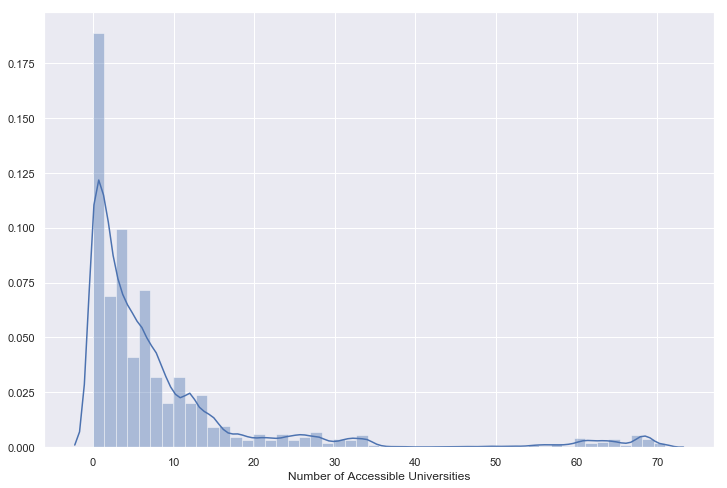

In [19]:
sns.distplot(merged_census_df['Number of Accessible Universities']);

__Let's do plus 1 smoothing on the number of accesible universities as well to ensure the LogNorm scaler does not return any errors for the education deserts with 0 accessible universities__

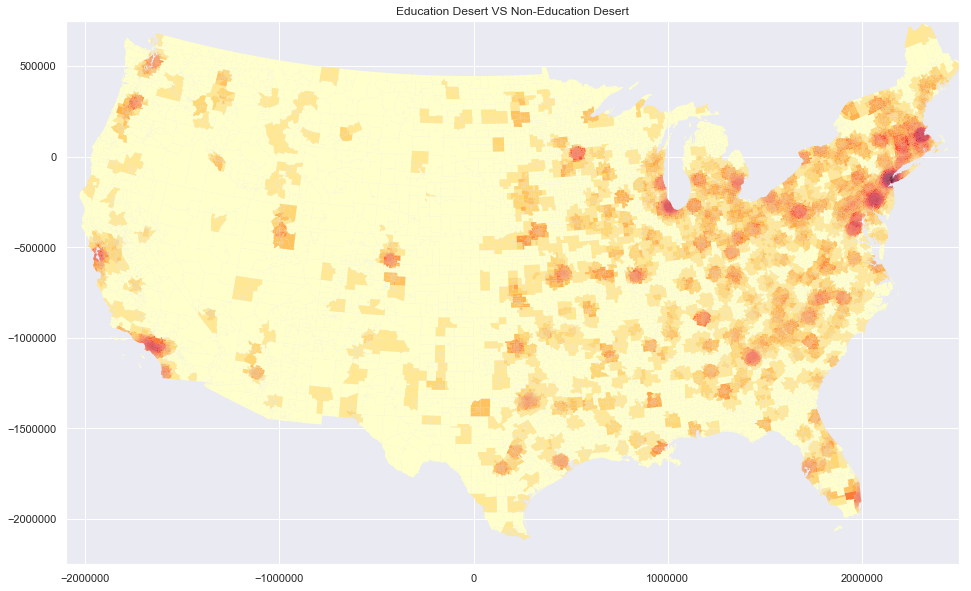

In [20]:
scaler = matplotlib.colors.LogNorm(vmin=merged_census_df['Number of Accessible Universities'].min() + 1, 
                                   vmax=merged_census_df['Number of Accessible Universities'].max() + 1)

fig, ax = plt.subplots(1, 1, figsize=(16, 10), sharex=True)

for idx, (ed_tract, n_unis) in enumerate(education_deserts):
    ax.add_patch(PolygonPatch(ed_tract, fc=plt.cm.YlOrRd(scaler(n_unis + 1)), ec=[1,1,1], linewidth=0.01))
    
for idx, (non_ed_tract, n_unis) in enumerate(non_education_deserts):
    G = n_unis/merged_census_df['Number of Accessible Universities'].max()
    ax.add_patch(PolygonPatch(non_ed_tract, fc=plt.cm.YlOrRd(scaler(n_unis + 1)), ec=[1,1,1], linewidth=0.01))
        
ax.set_xlim(left=-2.10*1e6, right=2.5*1e6)
ax.set_ylim(bottom=-2.25*1e6, top=0.75*1e6)
ax.set_title('Education Desert VS Non-Education Desert')
plt.grid(True)
plt.show();

In [21]:
x = pd.read_csv('output.txt',sep=":",header=None)
x.columns = ['geoid','value']
x.index = x['geoid']
x = x.drop(['geoid'], axis=1)
x.head()

,value
geoid,
37103920100,36761.964069
72127010200,28954.784840
28059040300,20778.899123
35045000505,15672.291748
22011960500,14905.928233


In [22]:
len(x)

100

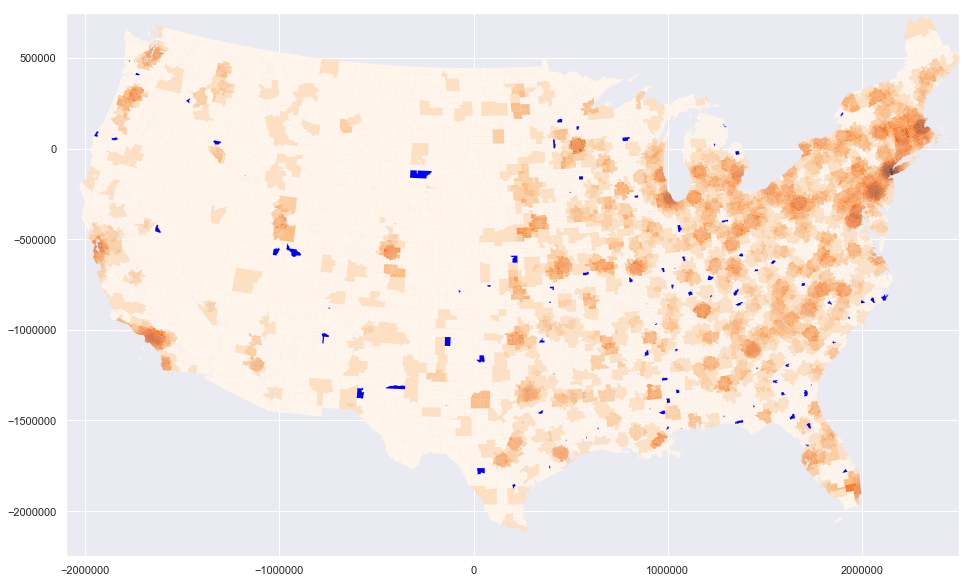

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10), sharex=True)

for idx, (ed_tract, n_unis) in enumerate(education_deserts):
    ax.add_patch(PolygonPatch(ed_tract, fc=plt.cm.Oranges(scaler(n_unis + 1)), ec=[1,1,1], linewidth=0.01))
    
for idx, (non_ed_tract, n_unis) in enumerate(non_education_deserts):
    G = n_unis/merged_census_df['Number of Accessible Universities'].max()
    ax.add_patch(PolygonPatch(non_ed_tract, fc=plt.cm.Oranges(scaler(n_unis + 1)), ec=[1,1,1], linewidth=0.01))
    
for idx, (geoid, value) in enumerate(x.iterrows()):
    ax.add_patch(PolygonPatch(tract_gdf.loc[str(geoid)].geometry, fc='blue', ec=[1,1,1], linewidth=0.01))

ax.set_xlim(left=-2.10*1e6, right=2.5*1e6)
ax.set_ylim(bottom=-2.25*1e6, top=0.75*1e6)  
plt.grid(True)
plt.show();

__Hawaii and ALaska does not have any new universities added and so were ommitted from the graph__

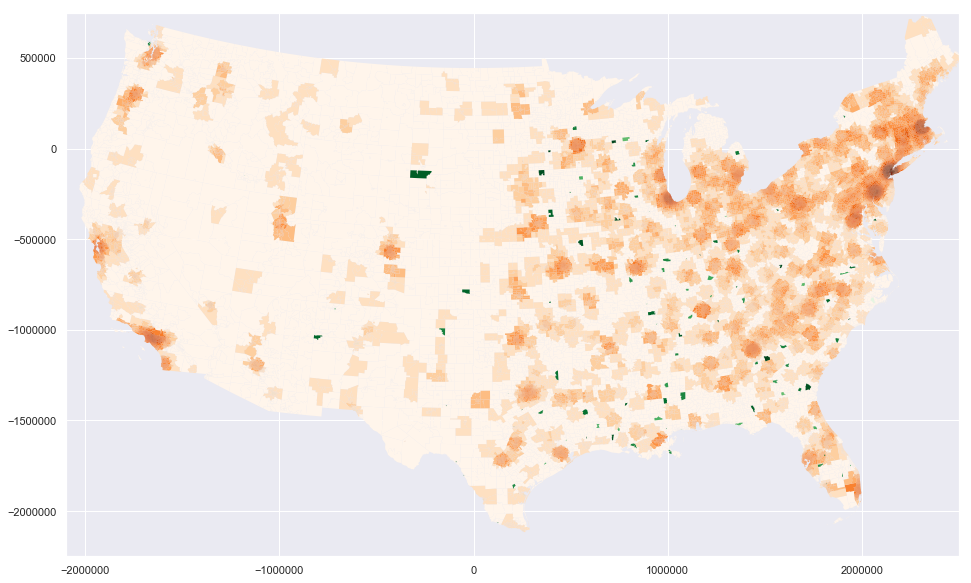

In [24]:
y = pd.read_csv('output2.txt',sep=":",header=None)
y.columns = ['geoid','value']
y.index = y['geoid']
y = y.drop(['geoid'], axis=1)

y_money_scaler = matplotlib.colors.LogNorm(vmin=y.values.min(), 
                                           vmax=y.values.max())

fig, ax = plt.subplots(1, 1, figsize=(16, 10), sharex=True)

for idx, (ed_tract, n_unis) in enumerate(education_deserts):
    ax.add_patch(PolygonPatch(ed_tract, fc=plt.cm.Oranges(scaler(n_unis + 1)), ec=[1,1,1], linewidth=0.01))
    
for idx, (non_ed_tract, n_unis) in enumerate(non_education_deserts):
    G = n_unis/merged_census_df['Number of Accessible Universities'].max()
    ax.add_patch(PolygonPatch(non_ed_tract, fc=plt.cm.Oranges(scaler(n_unis + 1)), ec=[1,1,1], linewidth=0.01))
    
for idx, (geoid, value) in enumerate(y.iterrows()):
    ax.add_patch(PolygonPatch(tract_gdf.loc[str(geoid)].geometry, fc=plt.cm.Greens_r(y_money_scaler(float(value))), ec=[1,1,1], linewidth=0.01))

ax.set_xlim(left=-2.10*1e6, right=2.5*1e6)
ax.set_ylim(bottom=-2.25*1e6, top=0.75*1e6)  
plt.grid(True)
plt.show();

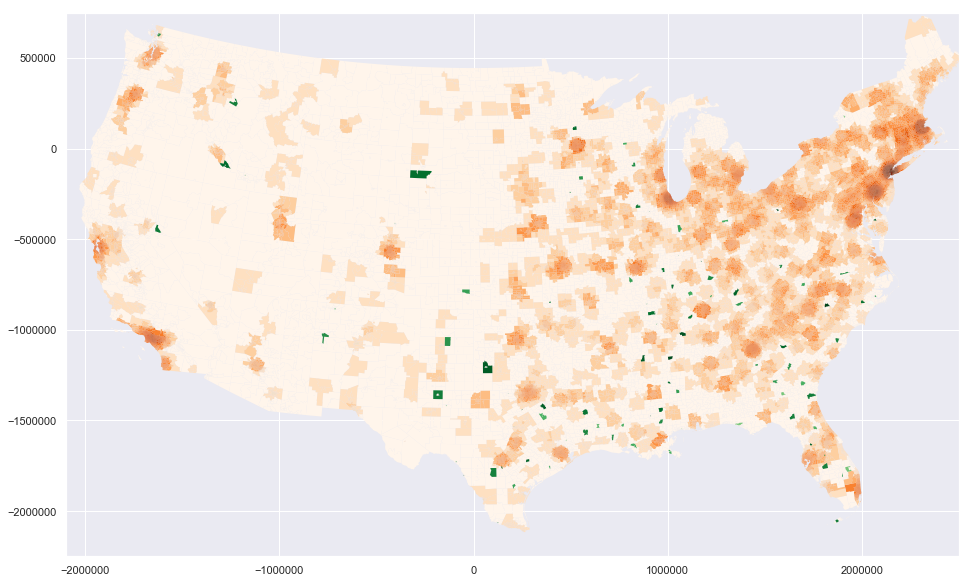

In [25]:
z = pd.read_csv('output3.txt',sep=":",header=None)
z.columns = ['geoid','value']
z.index = z['geoid']
z = z.drop(['geoid'], axis=1)

z_money_scaler = matplotlib.colors.LogNorm(vmin=z.values.min(), 
                                           vmax=z.values.max())

fig, ax = plt.subplots(1, 1, figsize=(16, 10), sharex=True)

for idx, (ed_tract, n_unis) in enumerate(education_deserts):
    ax.add_patch(PolygonPatch(ed_tract, fc=plt.cm.Oranges(scaler(n_unis + 1)), ec=[1,1,1], linewidth=0.01))
    
for idx, (non_ed_tract, n_unis) in enumerate(non_education_deserts):
    G = n_unis/merged_census_df['Number of Accessible Universities'].max()
    ax.add_patch(PolygonPatch(non_ed_tract, fc=plt.cm.Oranges(scaler(n_unis + 1)), ec=[1,1,1], linewidth=0.01))
    
for idx, (geoid, value) in enumerate(z.iterrows()):
    ax.add_patch(PolygonPatch(tract_gdf.loc[str(geoid)].geometry, fc=plt.cm.Greens_r(z_money_scaler(float(value))), ec=[1,1,1], linewidth=0.01))

ax.set_xlim(left=-2.10*1e6, right=2.5*1e6)
ax.set_ylim(bottom=-2.25*1e6, top=0.75*1e6)  
plt.grid(True)
plt.show();